In [2]:
# ===============================================
# BLOCK 1 — LOAD DATA & SETUP  /  VERIYI YUKLE & AYARLA
# ===============================================
# This block loads the e-commerce churn dataset, prepares the target column (Churn),
# and creates per-class DataFrames for later statistical tests.
# Bu blok e-ticaret churn veri setini yukler, hedef degisken (Churn) sutununu hazirlar
# ve istatistiksel testlerde kullanilmak uzere sinif bazli DataFrame'ler olusturur.

import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats as st
from statsmodels.stats.multitest import multipletests


# Input / Output paths
INPUT_PATH = r"C:\Users\ulku\Desktop\ecommerce\statisticaltest\ecommerceChurnDataset.xlsx"
OUT_DIR    = Path(r"C:\Users\ulku\Desktop\ecommerce\statisticaltest\statisticsforfeatures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_CSV  = OUT_DIR / "feature_tests_all_vars.csv"
OUT_XLSX = OUT_DIR / "feature_tests_all_vars.xlsx"

# ---- Load raw data (we never modify this file) ----
# ---- Ham veriyi yukle (bu Excel dosyasini hiç degistirmiyoruz) ----
df_raw = pd.read_excel(INPUT_PATH)
df_raw.columns = [c.strip() for c in df_raw.columns]

# Work on a copy so that df_raw stays untouched
# Orijinali bozmamak icin yeni bir kopya uzerinde calisiyoruz
df = df_raw.copy()

# ---- Minimal cleaning for some text columns ----
# ---- Bazi metin sutunlari icin minimum temizlik ----
str_cols = [
    "PreferredLoginDevice",
    "PreferredPaymentMode",
    "Gender",
    "PreferedOrderCat",
    "MaritalStatus",
]

for col in str_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.strip()
            .str.replace("\n", " ")
        )

# ---- Ensure Churn exists and is numeric 0/1 ----
# ---- Churn sutununun var oldugundan ve sayisal (0/1) oldugundan emin ol ----
if "Churn" not in df.columns:
    raise ValueError("Dataset must contain a 'Churn' column with values 0/1.")

df["Churn"] = pd.to_numeric(df["Churn"], errors="coerce")

# Drop rows with missing Churn
# Churn degeri eksik olan satirlari at
df = df.dropna(subset=["Churn"])
df["Churn"] = df["Churn"].astype(int)

# ---- Define classes (0 / 1) ----
# ---- Siniflari belirle (0 / 1) ----
classes = sorted(df["Churn"].unique())
if len(classes) != 2:
    raise ValueError(f"Churn must be binary (0/1). Found: {classes}")

class0, class1 = classes
df["Churn"] = df["Churn"].astype(int)

# ---- Split DataFrame per class ----
# ---- Her sinif icin ayri DataFrame olustur ----
df0 = df[df["Churn"] == class0]
df1 = df[df["Churn"] == class1]

print("Data shape after target prep / Hedef etiketine göre hazirlik sonrasi veri sekli:", df.shape)
print("Churn value counts:\n", df["Churn"].value_counts())


Data shape after target prep / Hedef etiketine göre hazirlik sonrasi veri sekli: (5630, 20)
Churn value counts:
 Churn
0    4682
1     948
Name: count, dtype: int64


In [3]:
# ===============================================
# BLOCK 2 — HELPER FUNCTIONS  /  YARDIMCI FONKSIYONLAR
# ===============================================
# Helper functions for effect sizes and statistics.
# Etki buyuklukleri ve istatistikler icin yardimci fonksiyonlar.

def cohen_d_welch(a, b):
    """
    Cohen's d with Welch pooled SD (for unequal variances).
    Esit olmayan varyans icin (Welch) havuzlanmis standart sapma ile Cohen's d.
    """
    a = np.asarray(a, float); b = np.asarray(b, float)
    a = a[~np.isnan(a)]; b = b[~np.isnan(b)]
    if a.size < 2 or b.size < 2:
        return np.nan
    s1 = np.std(a, ddof=1); s0 = np.std(b, ddof=1)
    sp = np.sqrt((s1**2 + s0**2) / 2)
    if sp == 0 or np.isnan(sp):
        return np.nan
    return (a.mean() - b.mean()) / sp


def cliffs_delta(a, b):
    """
    Cliff's delta for ordinal effect size.
    Sirali (ordinal) etki buyuklugu icin Cliff's delta .
    """
    a = np.asarray(a, float); b = np.asarray(b, float)
    a = a[~np.isnan(a)]; b = b[~np.isnan(b)]
    if len(a) == 0 or len(b) == 0: return np.nan
    total = 0
    # searchsorted ile hizli sayim
    for x in np.sort(a):
        lt = np.searchsorted(b, x, "left")
        gt = len(b) - np.searchsorted(b, x, "right")
        total += (lt - gt)
    return total / (len(a) * len(b))


def phi_from_table(tab2x2):
    """
    Compute Phi coefficient from a 2x2 contingency table.
    2x2 kontenjans tablosundan Phi katsayisini hesaplar.
    """
    chi2 = st.chi2_contingency(tab2x2, correction=False)[0]
    n = tab2x2.sum()
    return np.sqrt(chi2 / n) if n > 0 else np.nan


In [4]:
# ===============================================
# BLOCK 3 — COLUMN DETECTION  /  SUTUN TIPI BELIRLEME
# ===============================================
# Detect numeric and categorical columns for statistical tests.
# Istatistiksel testler icin sayisal ve kategorik kolonlari belirler.

# ---- Binary categorical columns (for Fisher test) ----
# ---- Ikili kategorik sutunlar (Fisher testi icin) ----
cat_cols = []
for col in ["Gender", "Complain"]:
    if col in df.columns and df[col].dropna().nunique() == 2:
        cat_cols.append(col)

# ---- Numeric columns: only truly numeric dtypes ----
# ---- Sayisal sutunlar: sadece gercekten sayisal tiptekiler ----
num_cols = []
for c in df.columns:
    # Exclude target, ID, and categorical columns
    # Hedefi, ID'yi ve kategorik sutunlari sayisal listeden cikart
    if c in ["Churn", "CustomerID"] + cat_cols:
        continue

    if pd.api.types.is_numeric_dtype(df[c]):
        num_cols.append(c)
    else:
        try:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            num_cols.append(c)
        except:
            pass

print("Numeric columns (num_cols):", num_cols)
print("Binary categorical columns (cat_cols):", cat_cols)



Numeric columns (num_cols): ['Tenure', 'PreferredLoginDevice', 'CityTier', 'WarehouseToHome', 'PreferredPaymentMode', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
Binary categorical columns (cat_cols): ['Gender', 'Complain']


In [5]:
# ===============================================
# BLOCK 4 — STATISTICAL TESTING FOR NUMERIC FEATURES
# ===============================================
# Run statistical tests (Welch t-test, Mann–Whitney, Levene, etc.) for numeric features.
# Sayisal degiskenler icin Welch t-testi, Mann–Whitney, Levene vb. istatistiksel testleri calistir.

results = []

for col in num_cols:
    # Extra safety: coerce to numeric and drop invalid values
    # Ek guvenlik: veriyi sayiya cevir, cevrilemeyenleri (NaN) at
    x0 = pd.to_numeric(df0[col], errors="coerce").dropna().values.astype(float)
    x1 = pd.to_numeric(df1[col], errors="coerce").dropna().values.astype(float)
    n0, n1 = len(x0), len(x1)

    if n0 < 2 or n1 < 2:
        results.append({
            'feature': col, 'type': 'continuous',
            'n_class0': n0, 'n_class1': n1,
            'mean_class0': np.nan, 'mean_class1': np.nan,
            'median_class0': np.nan, 'median_class1': np.nan,
            'delta_mean_(1-0)': np.nan,
            't_p_two_sided': np.nan,
            'mw_p_two_sided': np.nan,
            'levene_p': np.nan,
            'cohen_d': np.nan,
            'cliffs_delta': np.nan
        })
        continue

    # ---- Core statistics  /  Temel istatistikler ----
    mean0, mean1 = x0.mean(), x1.mean()
    med0,  med1  = np.median(x0), np.median(x1)
    delta = mean1 - mean0

    # ---- Welch t-test (unequal variances) ----
    # ---- Esit olmayan varyanslar icin Welch t-testi ----
    _, t_p = st.ttest_ind(x1, x0, equal_var=False, nan_policy="omit")

    # ---- Mann–Whitney U test (non-parametric) ----
    # ---- Mann–Whitney U testi (parametrik olmayan) ----
    u, mw_p = st.mannwhitneyu(x1, x0, alternative="two-sided", method="auto")

    # ---- Levene test for variance equality ----
    # ---- Varyans esitligi icin Levene testi ----
    _, lev_p = st.levene(x1, x0, center="median")

    # ---- Effect sizes  /  Etki buyuklukleri ----
    d  = cohen_d_welch(x1, x0)
    cd = cliffs_delta(x1, x0)

    results.append({
        'feature': col,
        'type': 'continuous',
        'n_class0': n0,
        'n_class1': n1,
        'mean_class0': mean0,
        'mean_class1': mean1,
        'median_class0': med0,
        'median_class1': med1,
        'delta_mean_(1-0)': delta,
        't_p_two_sided': t_p,
        'mw_p_two_sided': mw_p,
        'levene_p': lev_p,
        'cohen_d': d,
        'cliffs_delta': cd
    })


In [6]:
# ===============================================
# BLOCK 5 — CATEGORICAL TESTS (FISHER)  /  KATEGORIK TESTLER
# ===============================================
# Fisher exact test and related metrics for binary categorical features.
# Ikili kategorik degiskenler icin Fisher kesin testi ve ilgili metrikler.

for col in cat_cols:
    s0 = df0[col].dropna()
    s1 = df1[col].dropna()
    vals = sorted(df[col].dropna().unique())

    if len(vals) == 2:
        a0 = (s0 == vals[0]).sum(); b0 = (s0 == vals[1]).sum()
        a1 = (s1 == vals[0]).sum(); b1 = (s1 == vals[1]).sum()

        table = np.array([[a0, b0],
                          [a1, b1]])
        # Fisher exact test
        OR, p_fisher = st.fisher_exact(table)
        # Phi coefficient for 2x2 
        phi = phi_from_table(table)

        results.append({
            'feature': col,
            'type': 'categorical(2x2)',
            'n_class0': a0 + b0,
            'n_class1': a1 + b1,
            'mean_class0': np.nan,
            'mean_class1': np.nan,
            'median_class0': np.nan,
            'median_class1': np.nan,
            'delta_mean_(1-0)': np.nan,
            't_p_two_sided': np.nan,
            'mw_p_two_sided': np.nan,
            'levene_p': np.nan,
            'cohen_d': np.nan,
            'cliffs_delta': np.nan,
            'fisher_odds_ratio': OR,
            'fisher_p_two_sided': p_fisher,
            'phi_effect': phi
        })




In [7]:
# ===============================================
# BLOCK 6 — MULTIPLE TESTING CORRECTION (FDR + HOLM)
# ===============================================
# Correct p-values for multiple testing using FDR (BH) and Holm methods.
# Coklu test icin p-degerlerini FDR (BH) ve Holm yontemleriyle duzeltir.

res = pd.DataFrame(results)

def pick_primary_p(row):
    # For continuous features use Mann–Whitney p-value
    # Surekli degiskenlerde Mann–Whitney p-degerini kullan
    if row["type"].startswith("continuous"):
        return row["mw_p_two_sided"]
    # For categorical features use Fisher p-value
    # Kategorik degiskenlerde Fisher p-degerini kullan
    elif "categorical" in row["type"]:
        return row.get("fisher_p_two_sided", np.nan)
    else:
        return np.nan

res["p_primary"] = res.apply(pick_primary_p, axis=1)

mask = ~res["p_primary"].isna()
pvals = res.loc[mask, "p_primary"]

if len(pvals) > 0:
    _, p_fdr, _, _  = multipletests(pvals, method="fdr_bh")
    _, p_holm, _, _ = multipletests(pvals, method="holm")
    res.loc[mask, "p_FDR_BH"] = p_fdr
    res.loc[mask, "p_Holm"]   = p_holm
else:
    res["p_FDR_BH"] = np.nan
    res["p_Holm"]   = np.nan

res["sig_FDR<0.01"] = res["p_FDR_BH"] < 0.01

print("Number of features:", len(res))
print("Features with FDR<0.01:", res["sig_FDR<0.01"].sum())



Number of features: 18
Features with FDR<0.01: 8


In [8]:
# ===============================================
# BLOCK 7 — SAVE RESULTS  /  SONUCLARI KAYDET
# ===============================================
# Save all test results to CSV and Excel files.
# Tum test sonuclarini CSV ve Excel dosyalarina kaydeder.

res.to_csv(OUT_CSV, index=False)
with pd.ExcelWriter(OUT_XLSX) as writer:
    res.to_excel(writer, sheet_name="all_features", index=False)

print("Saved:")
print(" -", OUT_CSV)
print(" -", OUT_XLSX)



Saved:
 - C:\Users\ulku\Desktop\ecommerce\statisticaltest\statisticsforfeatures\feature_tests_all_vars.csv
 - C:\Users\ulku\Desktop\ecommerce\statisticaltest\statisticsforfeatures\feature_tests_all_vars.xlsx


In [9]:
# ===============================================
# BLOCK 8 — VISUALIZATION (VOLCANO & EFFECT SIZES)
# ===============================================
# Create volcano plot and effect size scatter plot for visual inspection.
# Gorsel inceleme icin volcano grafigi ve etki buyuklugu sacilim grafigi olusturur.

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text   # pip install adjustText (if needed)

sns.set(style="whitegrid")

df_vis = res.copy()
df_cont = df_vis[df_vis["type"] == "continuous"].copy()
df_cont["log10p"] = -np.log10(df_cont["p_FDR_BH"].replace(0, 1e-300))


Volcano plot saved as: C:\Users\ulku\Desktop\ecommerce\statisticaltest\statisticsforfeatures\volcano_plot.png


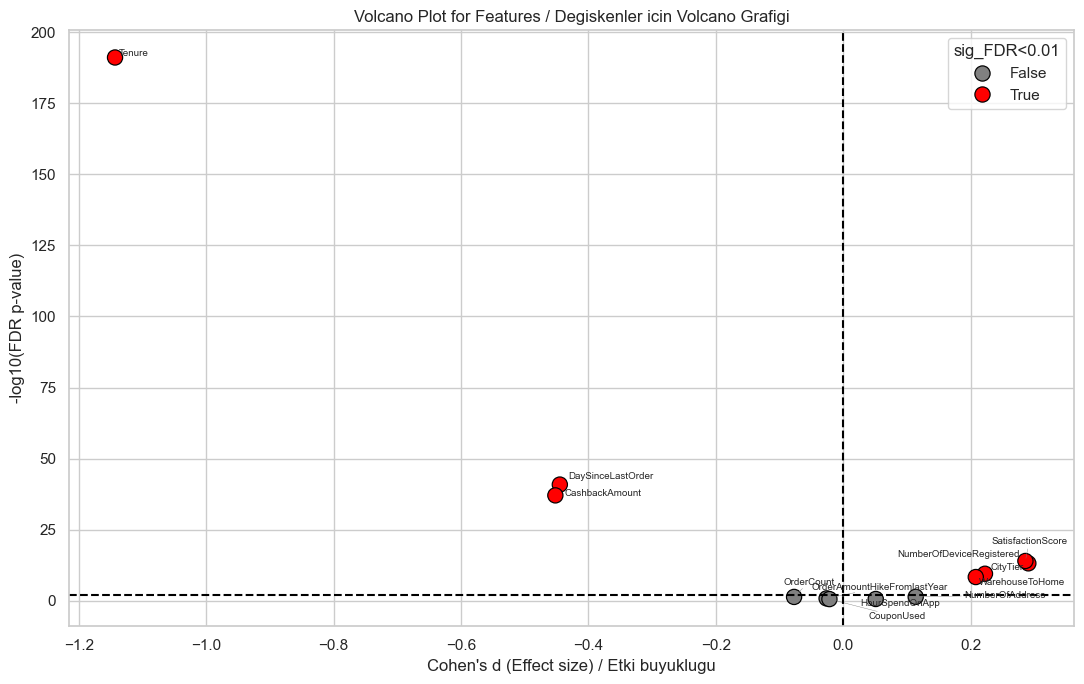

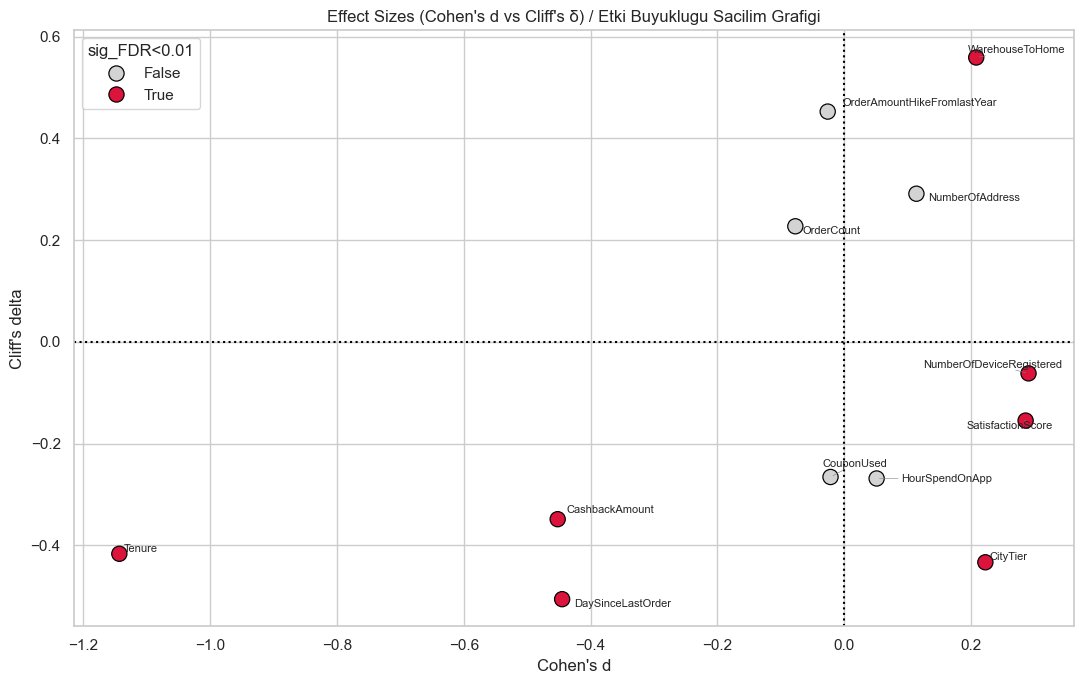


✓ Figures saved successfully with NON-EMPTY content. 


In [10]:
# ------------------------------------------------
# 8.1) VOLCANO PLOT
# ------------------------------------------------
# X: effect size (Cohen's d), Y: -log10(FDR-adjusted p-value)
# X: etki buyuklugu (Cohen's d), Y: -log10(FDR-duzeltilmis p-degeri)

fig, ax = plt.subplots(figsize=(11, 7))

sns.scatterplot(
    data=df_cont,
    x="cohen_d",
    y="log10p",
    hue="sig_FDR<0.01",
    palette={True: "red", False: "gray"},
    s=120,
    edgecolor="black",
    ax=ax
)

ax.axhline(-np.log10(0.01), linestyle="--", color="black")
ax.axvline(0, linestyle="--", color="black")
ax.set_xlabel("Cohen's d (Effect size) / Etki buyuklugu")
ax.set_ylabel("-log10(FDR p-value)")
ax.set_title("Volcano Plot for Features / Degiskenler icin Volcano Grafigi")

# ---- Label ALL features (only with finite coordinates) ----
# ---- Tum degiskenleri etiketle ama sadece sonlu (NaN olmayan) noktalar icin ----

import numpy as np

mask_finite = np.isfinite(df_cont["cohen_d"]) & np.isfinite(df_cont["log10p"])
points_to_label = df_cont[mask_finite].copy()

texts = []
for _, r in points_to_label.iterrows():
    t = ax.text(r["cohen_d"], r["log10p"], r["feature"], fontsize=7)
    texts.append(t)

# Etiketlerin çakışmasını azaltmak için adjust_text kullan
try:
    from adjustText import adjust_text
    adjust_text(
        texts,
        ax=ax,
        arrowprops=dict(arrowstyle="-", color="gray", lw=0.3)
    )
except ImportError:
    pass




if len(df_cont) > 0:
    fig.tight_layout()
    fig.savefig(OUT_DIR / "volcano_plot.png", dpi=300)
    print("Volcano plot saved as:", OUT_DIR / "volcano_plot.png")
else:
    print("No continuous features to plot in volcano plot.")

plt.show()
plt.close(fig)

# ------------------------------------------------
# 8.2) EFFECT SIZE SCATTER (Cohen's d vs Cliff's delta)
# ------------------------------------------------
# Scatter of two effect size measures for continuous features.
# Surekli degiskenler icin iki farkli etki buyuklugu olcusunun sacilim grafigi.

import numpy as np

# Sadece cohen_d ve cliffs_delta sonlu olan satirlari al
valid = df_cont.copy()
valid = valid.replace([np.inf, -np.inf], np.nan)
valid = valid.dropna(subset=["cohen_d", "cliffs_delta"])

fig, ax = plt.subplots(figsize=(11, 7))

sns.scatterplot(
    data=valid,
    x="cohen_d",
    y="cliffs_delta",
    hue="sig_FDR<0.01",
    palette={True: "crimson", False: "lightgray"},
    s=120,
    edgecolor="black",
    ax=ax
)

ax.axvline(0, linestyle=":", color="black")
ax.axhline(0, linestyle=":", color="black")
ax.set_xlabel("Cohen's d")
ax.set_ylabel("Cliff's delta")
ax.set_title("Effect Sizes (Cohen's d vs Cliff's δ) / Etki Buyuklugu Sacilim Grafigi")

# ---- Etiketler: yine sadece sonlu noktalar icin ----
texts = []
for _, r in valid.iterrows():
    t = ax.text(r["cohen_d"], r["cliffs_delta"], r["feature"], fontsize=8)
    texts.append(t)

try:
    from adjustText import adjust_text
    adjust_text(
        texts,
        ax=ax,
        arrowprops=dict(arrowstyle="-", color="gray", lw=0.4)
    )
except ImportError:
    pass

fig.tight_layout()
fig.savefig(OUT_DIR / "effectsize_scatter.png", dpi=300)
plt.show()
plt.close(fig)

print("\n✓ Figures saved successfully with NON-EMPTY content. ")